In [61]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

plt.rcParams['text.usetex'] = True
%config InlineBackend.figure_format = 'retina'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 18

from statsmodels.regression.linear_model import OLS

In [2]:
def VIF(X, idx):
    n_features = X.shape[1]
    x_i = X[:, idx]
    mask = np.arange(n_features) != idx
    X_i = X[:, mask]
    r_squared = OLS(x_i, X_i).fit().rsquared
    vif = 1. / np.maximum(1e-20, (1. - r_squared))
    return vif

In [3]:
class DataGenerator:
    def __init__(self, n_samples=10, n_features=10, n_targets=2, n_irrelevant=3, n_correlated=5):
        self.n_features = n_features
        self.n_samples = n_samples
        self.n_targets = n_targets
        self.n_irrelevant = n_irrelevant
        self.n_correlated = n_correlated
        
    def _get_y(self):
        y = np.random.randn(self.n_samples, self.n_targets)
        return y
    
    def _get_X(self):
        pass
    
    def generate(self):
        pass

In [4]:
dg = DataGenerator()
dg._get_y()

array([[ 1.27842244,  1.15360455],
       [-2.23289074, -0.41855513],
       [ 1.90717256,  0.89472689],
       [ 0.75335971, -2.18757167],
       [-0.41216181,  0.10634742],
       [ 0.21059396,  0.07770165],
       [ 0.55560887,  0.07669183],
       [-0.62662252,  0.31519045],
       [-0.27592517,  1.33732643],
       [ 0.29541106, -0.68798139]])

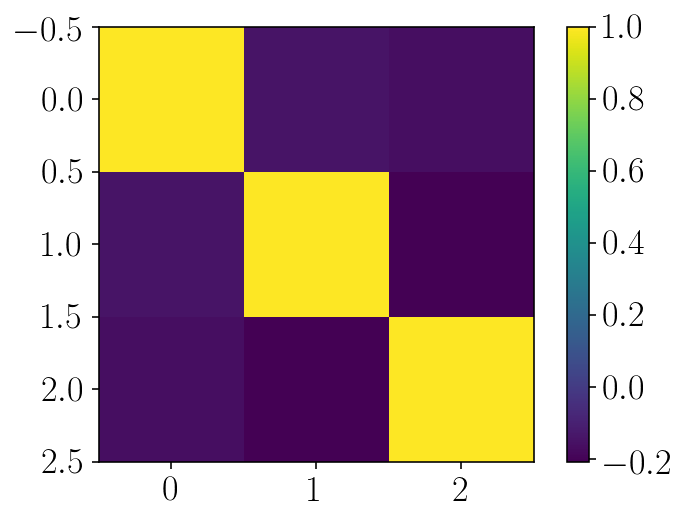

In [5]:
np.random.seed(30)

n_features = 3
n_samples = 100

X = np.random.randn(n_samples, n_features)
X = (X - X.mean(axis=0)) / X.std(axis=0)

plt.imshow(np.corrcoef(X.T))
plt.colorbar()
plt.show()

In [6]:
def generate_collinear_features(n, X):
    n_samples, n_features = X.shape
    X_new = np.zeros([X.shape[0], n])
    for i in range(n):
        n_cols = max(2, np.random.randint(n_features / 3) + 1)
        col_idxs = np.random.choice(np.arange(n_features), int(n_cols), replace=False)
        coef = np.random.rand(n_cols + 1)
        coef /= np.sqrt(np.sum(coef ** 2))
        col = X[:, col_idxs].dot(coef[:-1]) + coef[-1] * np.random.randn(n_samples)
        X_new[:, i] = (col - col.mean()) / col.std()
    return X_new

X_col = generate_collinear_features(20, X)

In [7]:
X = np.hstack([X, X_col])

n_samples, n_features = X.shape

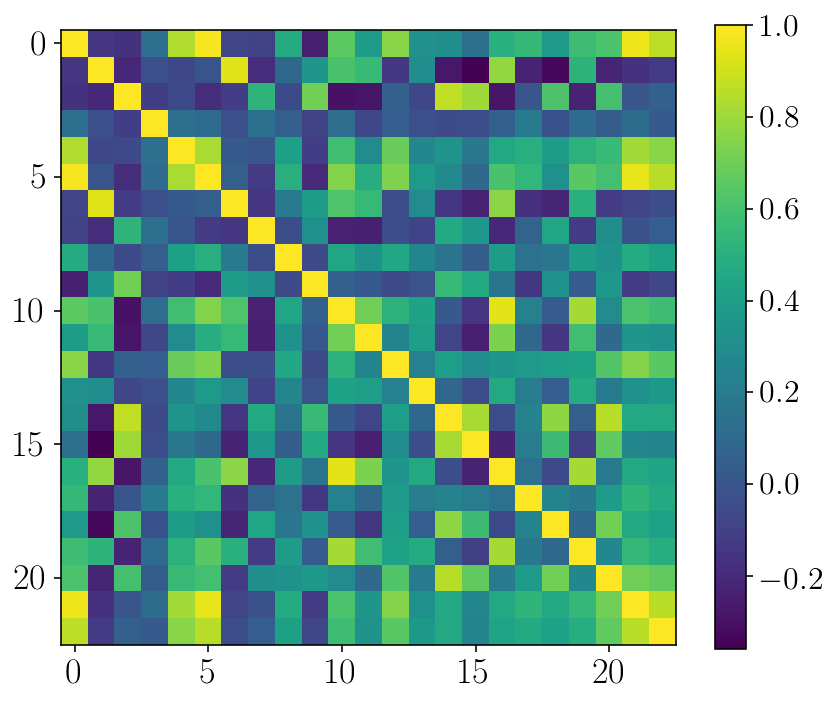

In [8]:
plt.figure(figsize=(6, 5))
plt.imshow(np.corrcoef(X.T))
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16) 
plt.tight_layout()
plt.show()

In [9]:
[VIF(X, i) for i in range(X.shape[1])]

[255.66112334971308,
 249.08679643246964,
 71.700870806321319,
 1.3597518713210106,
 4.1129505478168218,
 86.418861207091609,
 10.623147182277696,
 1.7708347905336421,
 1.5843445258825852,
 4.9870247078883887,
 23.172369305166391,
 2.7235152485704925,
 3.4059127327945573,
 1.6710210363595528,
 59.426618034492641,
 5.3576250855346919,
 284.22206794345396,
 1.9021677921349676,
 3.7940375893513374,
 3.9508825017299429,
 9.4258144384862312,
 31.0304691959481,
 6.2409464692971222]

In [60]:
import numpy as np
import sklearn.feature_selection as sklfs
import scipy as sc
import cvxpy as cvx


def corr(X, Y=None, fill=0):
    if Y is None:
        Y = X
    if len(Y.shape) == 1:
        Y = Y[:, np.newaxis]
    if len(X.shape) == 1:
        X = X[:, np.newaxis]
    
    X_ = (X - X.mean(axis=0))
    Y_ = (Y - Y.mean(axis=0))
    
    idxs_nz_x = np.where(np.sum(X_ ** 2, axis = 0) != 0)[0]
    idxs_nz_y = np.where(np.sum(Y_ ** 2, axis = 0) != 0)[0]
    
    X_ = X_[:, idxs_nz_x]
    Y_ = Y_[:, idxs_nz_y]
    
    corr = np.ones((X.shape[1], Y.shape[1])) * fill
    
    for i, x in enumerate(X_.T):
        corr[idxs_nz_x[i], idxs_nz_y] = Y_.T.dot(x) / np.sqrt(np.sum(x ** 2) * np.sum(Y_ ** 2, axis=0, keepdims=True))
    return corr


def shift_spectrum(Q):
    lamb_min = sc.linalg.eigh(Q)[0][0]
    if lamb_min < 0:
        Q = Q - lamb_min * np.eye(*Q.shape)
    return Q, lamb_min


class QPFS:
    def __init__(self, sim='corr'):
        if sim not in ['corr', 'info']:
            raise ValueError('Similarity measure should be "corr" or "info"')
        self.sim = sim
    
    def get_params(self, X, y):
        if self.sim == 'corr':
            self.Q = np.abs(corr(X, fill=1))
            self.b = np.sum(np.abs(corr(X, y)), axis=1)[:, np.newaxis]
        elif self.sim == 'info':
            self.Q = np.ones([X.shape[1], X.shape[1]])
            self.b = np.zeros((X.shape[1], 1))
            for j in range(n_features):
                self.Q[:, j] = sklfs.mutual_info_regression(X, X[:, j])
            if len(y.shape) == 1:
                self.b = sklfs.mutual_info_regression(X, y)[:, np.newaxis]
            else:
                for y_ in y:
                    self.b += sklfs.mutual_info_regression(X, y_)
        self.Q, self.lamb_min = shift_spectrum(self.Q)
    
    def get_alpha(self):
        return self.Q.mean() / (self.Q.mean() + self.b.mean())

    def fit(self, X, y):
        self.get_params(X, y)
        alpha = self.get_alpha()
        self.solve_problem(alpha)
    
    def solve_problem(self, alpha):
        n = self.Q.shape[0]
        x = cvx.Variable(n)
        c = np.ones((n, 1))
        objective = cvx.Minimize((1 - alpha) * cvx.quad_form(x, self.Q) - 
                                 alpha * self.b.T * x)
        constraints = [x >= 0, c.T * x == 1]
        prob = cvx.Problem(objective, constraints)

        prob.solve()

        self.status = prob.status
        self.score = np.array(x.value).flatten()
        
    def __repr__(self):
        return f'QPFS(sim="{self.sim}")'
        
    def get_topk_indices(self, k=10):
        return self.score.argsort()[::-1][:k]


class MultivariateQPFS():
    def __init__(self):
        pass
    
    def get_params(self, X, Y, eps=1e-12):
        self.Qx = np.abs(corr(X, fill=1))
        self.Qy = np.abs(corr(Y, fill=1))
        self.B = np.abs(corr(X, Y))

    def get_alpha(self, alpha3=0.1):
        alpha1 = (1 - alpha3) * np.mean(self.B) / (np.mean(self.Qx) + np.mean(self.B))
        alpha2 = (1 - alpha3) * np.mean(self.Qx) / (np.mean(self.Qx) + np.mean(self.B))
        return np.array([alpha1, alpha2, alpha3])


    def fit(self, X, Y):
        self.get_params(X, Y)
        alphas = self.get_alpha()
        self.solve_problem(alphas)
    
    def solve_problem(self, alphas):
        n = self.Qx.shape[0]
        r = self.Qy.shape[0]
        
        Q = np.vstack((np.hstack((alphas[0] * self.Qx, -alphas[1] / 2 * self.B)),
                       np.hstack(( -alphas[1] / 2 * self.B.T, alphas[2] * self.Qy))))
        Q, lamb_min = shift_spectrum(Q)
        
        a = cvx.Variable(n + r)
        
        c = np.zeros((2, n + r))
        c[0, :n] = 1
        c[1, n:] = 1
        
        objective = cvx.Minimize(cvx.quad_form(a, Q))
        constraints = [a >= 0, c * a == 1]
        prob = cvx.Problem(objective, constraints)

        prob.solve()

        self.status = prob.status
        self.score = np.array(a.value).flatten()
        
    def get_topk_indices(self, k=10):
        return self.score[self.B.shape[0]].argsort()[::-1][:k]
        
    def __repr__(self):
        return f'QPFS(sim="{self.sim}")'

In [11]:
from sklearn.datasets import load_boston

X, y = load_boston(return_X_y=True)
Y = np.repeat(y[:, np.newaxis], repeats=10, axis=1)
X = np.hstack([X, np.zeros((X.shape[0], 1))])

In [12]:
qpfs = QPFS()
qpfs.fit(X, y)
print(*['{:.4f}'.format(x) for x in qpfs.score], sep='\t')

0.0722	0.0607	0.0455	0.1049	0.0425	0.1967	0.0371	0.0000	0.0247	0.0492	0.1248	0.0866	0.1551	0.0000


In [13]:
qpfs = QPFS()
qpfs.fit(X, Y)
print(*['{:.4f}'.format(x) for x in qpfs.score], sep='\t')

0.0721	0.0607	0.0455	0.1049	0.0425	0.1967	0.0371	0.0000	0.0247	0.0492	0.1248	0.0866	0.1551	0.0000


In [14]:
qpfs2 = MultivariateQPFS()

qpfs2.get_params(X, y)

alpha = np.mean(qpfs2.Qx) / (np.mean(qpfs2.Qx) + np.mean(qpfs2.B))
qpfs2.solve_problem([1 - alpha, alpha, 0.])
print(*['{:.4f}'.format(x) for x in qpfs2.score], sep='\t')

0.0757	0.0677	0.0469	0.1153	0.0453	0.1787	0.0446	0.0000	0.0329	0.0494	0.1188	0.0908	0.1340	0.0000	1.0000


In [15]:
qpfs2 = MultivariateQPFS()

qpfs2.get_params(X, Y)

alpha = np.mean(qpfs2.Qx) / (np.mean(qpfs2.Qx) + np.mean(qpfs2.B))
qpfs2.solve_problem([1 - alpha, alpha, 0.])
print(*['{:.4f}'.format(x) for x in qpfs2.score], sep='\t')

0.0761	0.0704	0.0567	0.1058	0.0532	0.1466	0.0542	0.0251	0.0485	0.0576	0.1066	0.0858	0.1135	0.0000	0.1000	0.1000	0.1000	0.1000	0.1000	0.1000	0.1000	0.1000	0.1000	0.1000


In [16]:
Q = np.array([[1., 0., .0],
               [0., 1., 0.8],
               [.0, 0.8, 1.]])
Qx = Q.copy()
print(Q)
r = 5
Qy = np.ones((r, r)) * 0.2
Qy[:r - 1, :r - 1] = np.ones((r - 1, r - 1))
np.fill_diagonal(Qy, 1.)
print(Qy)
B = np.hstack((np.repeat(np.array([[0.4], [0.5], [0.8]]), repeats=r - 1, axis=1), np.array([[0.], [.8], [.1]])))
print(B[:, :17])
b = np.mean(B, axis=1, keepdims=True)
print(b)

[[ 1.   0.   0. ]
 [ 0.   1.   0.8]
 [ 0.   0.8  1. ]]
[[ 1.   1.   1.   1.   0.2]
 [ 1.   1.   1.   1.   0.2]
 [ 1.   1.   1.   1.   0.2]
 [ 1.   1.   1.   1.   0.2]
 [ 0.2  0.2  0.2  0.2  1. ]]
[[ 0.4  0.4  0.4  0.4  0. ]
 [ 0.5  0.5  0.5  0.5  0.8]
 [ 0.8  0.8  0.8  0.8  0.1]]
[[ 0.32]
 [ 0.56]
 [ 0.66]]


In [17]:
Q = shift_spectrum(Q)[0]
qpfs.Q, qpfs.b = Q, b
alpha = qpfs.get_alpha()
qpfs.solve_problem(alpha)
print(*['{:.4f}'.format(x) for x in qpfs.score], sep='\t')

0.3977	0.1767	0.4256


In [18]:
qpfs2.Qx = Qx
qpfs2.Qy = Qy
qpfs2.B = B

alpha3 = .3
alpha1 = (1 - alpha3) * np.mean(qpfs2.B) / (np.mean(qpfs2.Qx) + np.mean(qpfs2.B))
alpha2 = (1 - alpha3) * np.mean(qpfs2.Qx) / (np.mean(qpfs2.Qx) + np.mean(qpfs2.B))
alphas = np.array([alpha1, alpha2, alpha3])
print(alphas)
qpfs2.solve_problem(alphas)

print(*['{:.4f}'.format(x) for x in qpfs2.score], sep='\t')

[ 0.35075922  0.34924078  0.3       ]
0.3829	0.5346	0.0825	0.1296	0.1296	0.1296	0.1296	0.4816


In [19]:
alphas_history = []
score_history = []
alpha3_array = np.linspace(0, 1, 300)
for alpha3 in alpha3_array:
    alpha1 = (1 - alpha3) * np.mean(qpfs2.B) / (np.mean(qpfs2.Qx) + np.mean(qpfs2.B))
    alpha2 = (1 - alpha3) * np.mean(qpfs2.Qx) / (np.mean(qpfs2.Qx) + np.mean(qpfs2.B))
    alphas = np.array([alpha1, alpha2, alpha3])
    alphas_history.append(alphas)
    qpfs2.solve_problem(alphas)
    score_history.append(qpfs2.score)

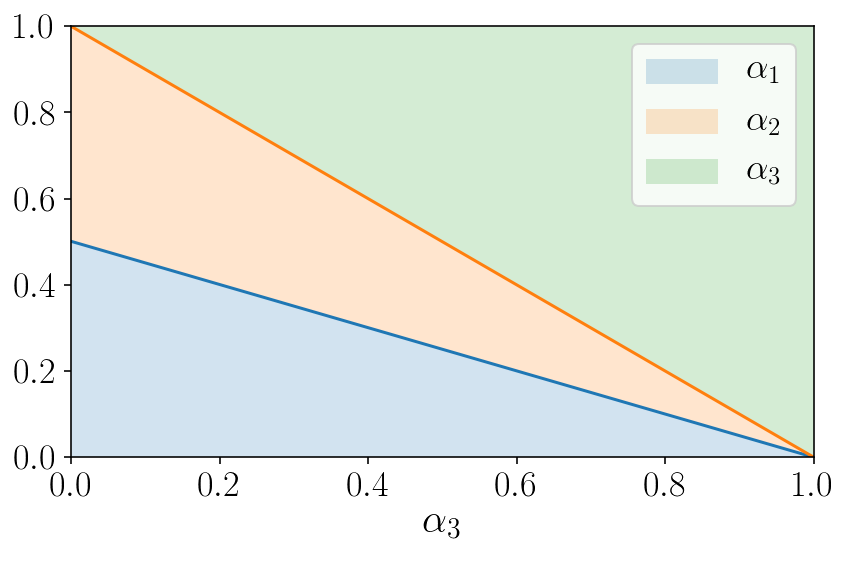

In [20]:
first_points = np.array([a[0] for a in alphas_history])
second_points = np.array([a[1] for a in alphas_history])
third_points = np.array([a[2] for a in alphas_history])

plt.plot(alpha3_array, first_points)
plt.fill_between(alpha3_array, first_points, alpha=0.2, label=r'$\alpha_1$')
plt.plot(alpha3_array, first_points + second_points)
plt.fill_between(alpha3_array, first_points + second_points, first_points, alpha=0.2, label=r'$\alpha_2$')
plt.fill_between(alpha3_array, 1., first_points + second_points, alpha=0.2, label=r'$\alpha_3$')

plt.ylim(0., 1.)
plt.xlim(0., 1.)

plt.legend()
plt.xlabel(r'$\alpha_3$')

plt.tight_layout()
plt.show()

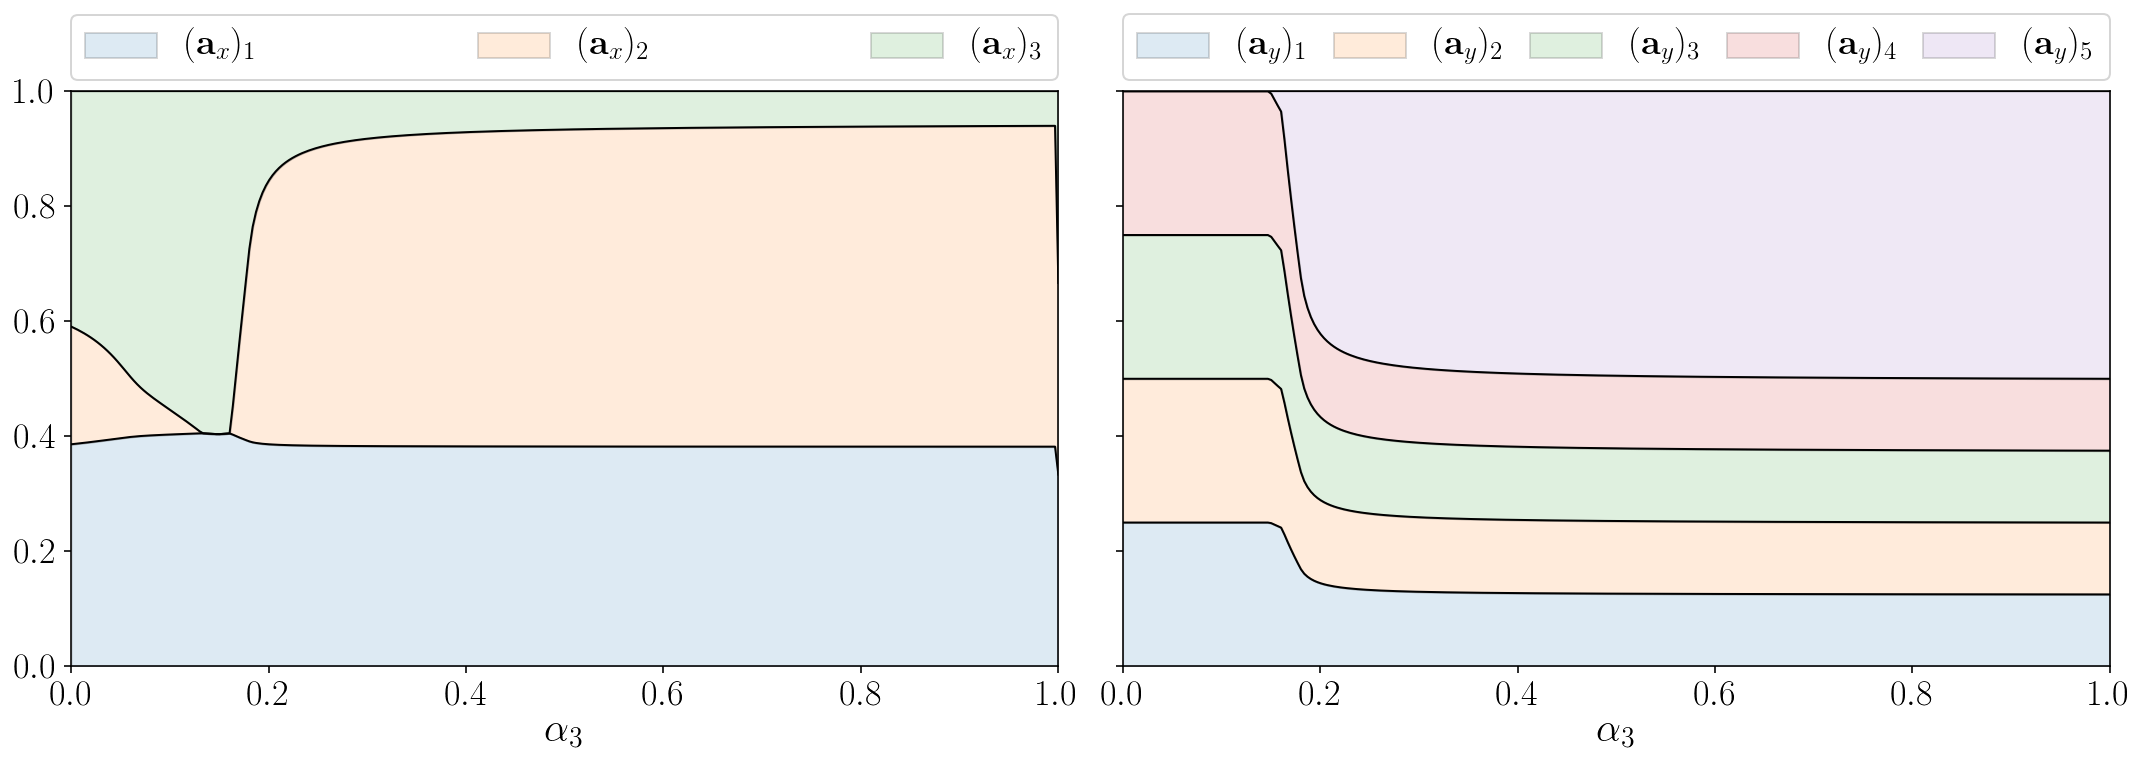

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
n_x, n_y = qpfs2.B.shape
prev = 0.
for i in range(n_x):
    cur = [np.sum(a[:i + 1]) for a in score_history]
    ax1.plot(alpha3_array, cur, c='k', linewidth=1.)
    ax1.fill_between(alpha3_array, cur, prev, edgecolor='k', alpha=.15, 
                     label=r'{}'.format('$(\mathbf{a}_x)_' + str(i + 1) + '$'))
    prev = cur

ax1.set_ylim(0., 1.)
ax1.set_xlim(0., 1.)

ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=n_x, mode="expand", borderaxespad=0., frameon=True)
ax1.set_xlabel(r'$\alpha_3$')

prev = 0.
for i in range(n_y):
    cur = [np.sum(a[n_x:n_x + i + 1]) for a in score_history]
    ax2.plot(alpha3_array, cur, c='k', linewidth=1.)
    ax2.fill_between(alpha3_array, cur, prev, alpha=0.15, edgecolor='k', 
                     label=r'{}'.format('$(\mathbf{a}_y)_' + str(i + 1) + '$'))
    prev = cur

ax2.set_ylim(0., 1.)
ax2.set_xlim(0., 1.)

lgd = ax2.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=n_y, mode="expand", borderaxespad=0., frameon=True)
ax2.set_xlabel(r'$\alpha_3$')

fig.tight_layout()
fig.subplots_adjust()
fig.savefig('figs/features_vs_alpha.eps', format='eps', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

### ECoG

In [23]:
Xtrain = sc.io.loadmat('./../data/ECoG_X_train.mat')['X_train'].reshape([-1, 32 * 27])
Ytrain = sc.io.loadmat('./../data/ECoG_Y_train.mat')['Y_train']

Xtest = sc.io.loadmat('./../data/ECoG_X_test.mat')['X_hold_out'].reshape([-1, 32 * 27])
Ytest = sc.io.loadmat('./../data/ECoG_Y_test.mat')['Y_hold_out']

n_samples, n_features = Xtrain.shape

print(Xtrain.shape, Ytrain.shape)
print(Xtest.shape, Ytest.shape)

(12801, 864) (12801, 3)
(6087, 864) (6087, 3)


In [24]:
np.corrcoef(Ytrain.T)

array([[ 1.        , -0.43997781,  0.22172754],
       [-0.43997781,  1.        , -0.31678687],
       [ 0.22172754, -0.31678687,  1.        ]])

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(Xtrain, Ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [55]:
def RMSE(y, p):
    return np.sqrt(np.mean((y - p) ** 2))

In [26]:
pred = lr.predict(Xtrain)
print('train: ', mean_squared_error(Ytrain, pred))

pred = lr.predict(Xtest)
print('test: ', mean_squared_error(Ytest, pred))

train:  1477.75062037
test:  1786.77876919


In [27]:
qpfs = QPFS()

qpfs.fit(Xtrain, Ytrain)

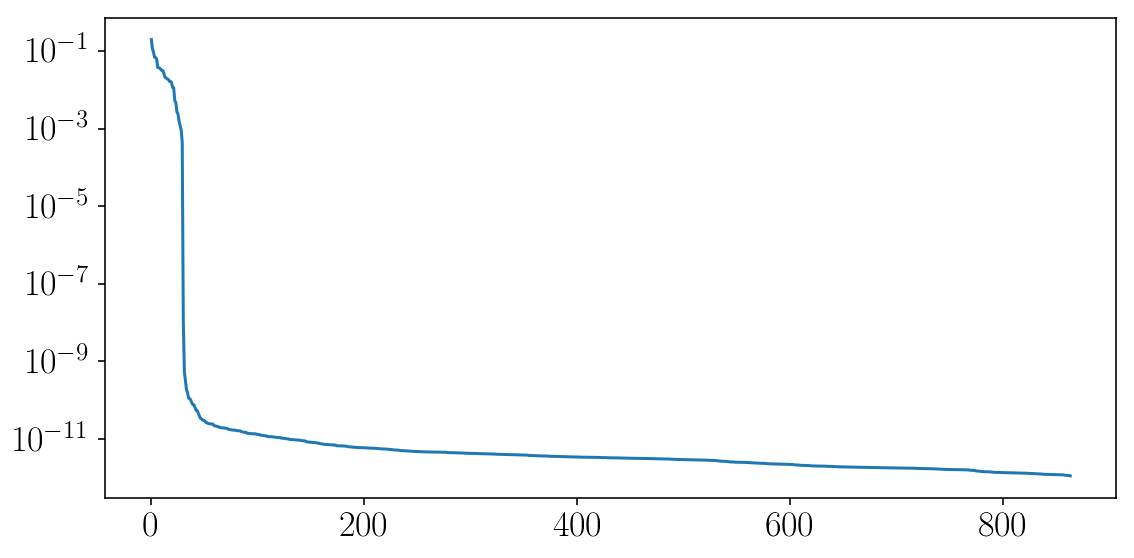

In [77]:
plt.figure(figsize=(8, 4))
plt.semilogy(sorted(qpfs.score)[::-1])
plt.tight_layout()
plt.savefig('figs/feature_scores_ex.eps', format='eps')
plt.show()

In [56]:
k = 200
active_idxs = qpfs.score.argsort()[::-1][:200]
lr.fit(Xtrain[:, active_idxs], Ytrain)

pred = lr.predict(Xtrain[:, active_idxs])
print('train: ', RMSE(Ytrain, pred))

pred = lr.predict(Xtest[:, active_idxs])
print('test: ', RMSE(Ytest, pred))

train:  42.6338885951
test:  42.1127333117


In [57]:
n_active_array = np.arange(1, n_features, 10)
train_err_array = []
test_err_array = []
for k in n_active_array:
    active_idxs = qpfs.score.argsort()[::-1][:k]
    lr.fit(Xtrain[:, active_idxs], Ytrain)
    pred = lr.predict(Xtrain[:, active_idxs])
    train_err_array.append(RMSE(Ytrain, pred))
    pred = lr.predict(Xtest[:, active_idxs])
    test_err_array.append(RMSE(Ytest, pred))
    
train_err_array = np.array(train_err_array)
test_err_array = np.array(test_err_array)

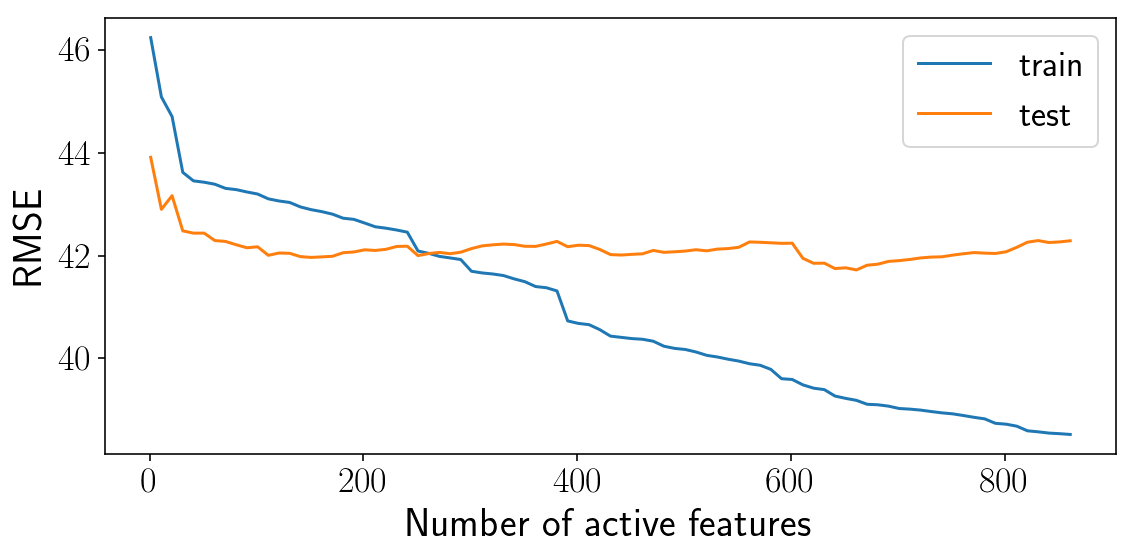

In [76]:
plt.figure(figsize=(8, 4))
plt.plot(n_active_array, train_err_array, label='train')
plt.plot(n_active_array, test_err_array, label='test')
plt.xlabel('Number of active features')
plt.ylabel('RMSE')
plt.legend()
plt.tight_layout()
plt.savefig('figs/train_test_qpfs.eps', format='eps')
plt.show()

In [63]:
mqpfs = MultivariateQPFS()
mqpfs.get_params(Xtrain, Ytrain)

In [74]:
alphas_history = []
score_history = []
alpha3_array = np.linspace(0, 1, 20)
for alpha3 in tqdm(alpha3_array):
    alphas = mqpfs.get_alpha(alpha3)
    mqpfs.solve_problem(alphas)
    alphas_history.append(alphas)
    score_history.append(mqpfs.score)

100%|██████████| 20/20 [04:07<00:00, 12.36s/it]


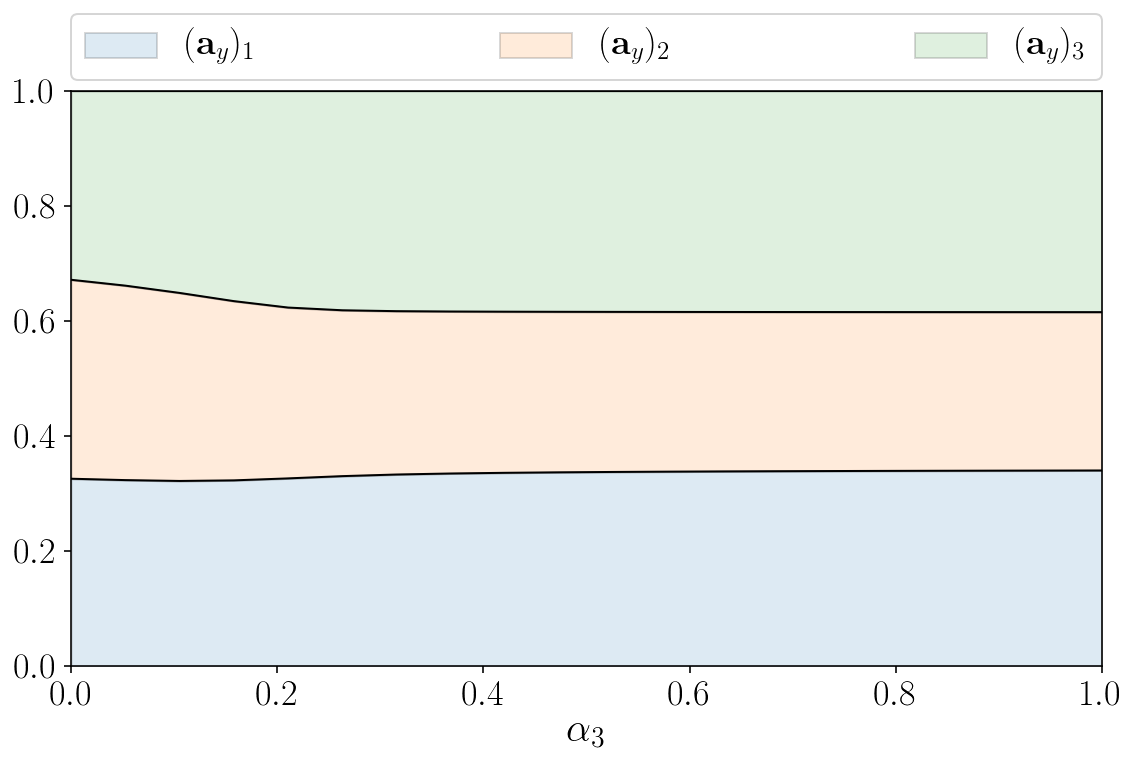

In [79]:
n_x, n_y = mqpfs.B.shape

plt.figure(figsize=(8, 5))

prev = 0.
for i in range(n_y):
    cur = [np.sum(a[n_x:n_x + i + 1]) for a in score_history]
    plt.plot(alpha3_array, cur, c='k', linewidth=1.)
    plt.fill_between(alpha3_array, cur, prev, alpha=0.15, edgecolor='k', 
                     label=r'{}'.format('$(\mathbf{a}_y)_' + str(i + 1) + '$'))
    prev = cur

plt.ylim(0., 1.)
plt.xlim(0., 1.)

lgd = plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=n_y, mode="expand", borderaxespad=0., frameon=True)
plt.xlabel(r'$\alpha_3$')

plt.tight_layout()
plt.savefig('figs/features_vs_alpha_ecog_3.pdf', format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [81]:
alphas_history

[array([ 0.16736482,  0.83263518,  0.        ]),
 array([ 0.15855615,  0.78881228,  0.05263158]),
 array([ 0.14974747,  0.74498937,  0.10526316]),
 array([ 0.1409388 ,  0.70116647,  0.15789474]),
 array([ 0.13213012,  0.65734356,  0.21052632]),
 array([ 0.12332145,  0.61352066,  0.26315789]),
 array([ 0.11451277,  0.56969775,  0.31578947]),
 array([ 0.1057041 ,  0.52587485,  0.36842105]),
 array([ 0.09689542,  0.48205195,  0.42105263]),
 array([ 0.08808675,  0.43822904,  0.47368421]),
 array([ 0.07927807,  0.39440614,  0.52631579]),
 array([ 0.0704694 ,  0.35058323,  0.57894737]),
 array([ 0.06166072,  0.30676033,  0.63157895]),
 array([ 0.05285205,  0.26293743,  0.68421053]),
 array([ 0.04404337,  0.21911452,  0.73684211]),
 array([ 0.0352347 ,  0.17529162,  0.78947368]),
 array([ 0.02642602,  0.13146871,  0.84210526]),
 array([ 0.01761735,  0.08764581,  0.89473684]),
 array([ 0.00880867,  0.0438229 ,  0.94736842]),
 array([ 0.,  0.,  1.])]